In [19]:
###################Import Required libraries####################
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential, save_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras import optimizers
from keras.callbacks import EarlyStopping

In [20]:
#######################preprocess data using Data Augmentation###########
def prepare_data(train_dir, validation_dir, target_size, batch_size):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=90,
        fill_mode='nearest',
        cval=0xCC,
        horizontal_flip=True,
        vertical_flip=True,
        channel_shift_range=100
    )

    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator



In [21]:
################Function to use pretrained model (EfficientB0) with custom classifier#######
def build_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation="softmax"))

    return model


In [22]:
#####################Function to train model###################
def train_model(model, train_generator, validation_generator, epochs, steps_per_epoch, validation_steps):
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=1e-2),
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    return history


In [23]:
################Function to evaluate the model performance#################
def evaluate_model(model, test_generator, test_steps):
    evaluation = model.evaluate(test_generator, steps=test_steps)
    print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))


In [24]:
####################function to plot the learning curves############
def plot_history(history, save_path=None):
    # Plot Training History
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('EfficientNetB0 Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    if save_path:
        plt.savefig(os.path.join(save_path, 'accuracy_plot.png'))
    else:
        plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('EfficientNetB0 Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    if save_path:
        plt.savefig(os.path.join(save_path, 'loss_plot.png'))
    else:
        plt.show()

In [25]:
###################Function to save the model#########################
def save_model(model, save_path='/kaggle/working/efficNetB0.h5'):
    """
    Save the trained model weights.

    Args:
        model (Sequential): Trained Keras model.
        save_path (str): Path to save the model weights.
    """
    model.save(save_path)

In [26]:
def main(): 
    
    # Set your parameters
    batch_size = 64
    IMG_WIDTH = 224
    IMG_HEIGHT = 224
    CHANNELS = 3
    CLASSES = 6
    train_dir = '/kaggle/input/hist-train-test/train_test_dataset/train'
    validation_dir = '/kaggle/input/hist-train-test/train_test_dataset/test'

    # Build Model
    model = build_model((IMG_WIDTH, IMG_HEIGHT, CHANNELS), CLASSES)

    # Prepare Data
    train_generator, validation_generator = prepare_data(train_dir, validation_dir, (IMG_WIDTH, IMG_HEIGHT), batch_size)

    # Train Model
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
    epochs = 10

    history = train_model(model, train_generator, validation_generator, epochs, STEP_SIZE_TRAIN, STEP_SIZE_VALID)

    # Evaluate on Test Data
    evaluate_model(model, validation_generator, STEP_SIZE_VALID)

    # Plot and Save History
    plot_history(history)#/kaggle/working/'
    save_model(model)

Found 4452 images belonging to 6 classes.
Found 1113 images belonging to 6 classes.
Epoch 1/10


2024-01-31 14:24:10.223945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


69/69 [==============================] - 146s 2s/step - loss: 0.7328 - accuracy: 0.7345 - val_loss: 0.4543 - val_accuracy: 0.8438
Epoch 2/10
69/69 [==============================] - 135s 2s/step - loss: 0.5151 - accuracy: 0.8086 - val_loss: 0.3840 - val_accuracy: 0.8640
Epoch 3/10
69/69 [==============================] - 139s 2s/step - loss: 0.4575 - accuracy: 0.8325 - val_loss: 0.4006 - val_accuracy: 0.8548
Epoch 4/10
69/69 [==============================] - 137s 2s/step - loss: 0.4518 - accuracy: 0.8366 - val_loss: 0.4209 - val_accuracy: 0.8585
Epoch 5/10
69/69 [==============================] - 141s 2s/step - loss: 0.4208 - accuracy: 0.8494 - val_loss: 0.3634 - val_accuracy: 0.8897
Epoch 6/10
69/69 [==============================] - 140s 2s/step - loss: 0.4132 - accuracy: 0.8507 - val_loss: 0.3585 - val_accuracy: 0.8768
Epoch 7/10
69/69 [==============================] - 140s 2s/step - loss: 0.4374 - accuracy: 0.8491 - val_loss: 0.3836 - val_accuracy: 0.8732
Epoch 8/10
69/69 [======

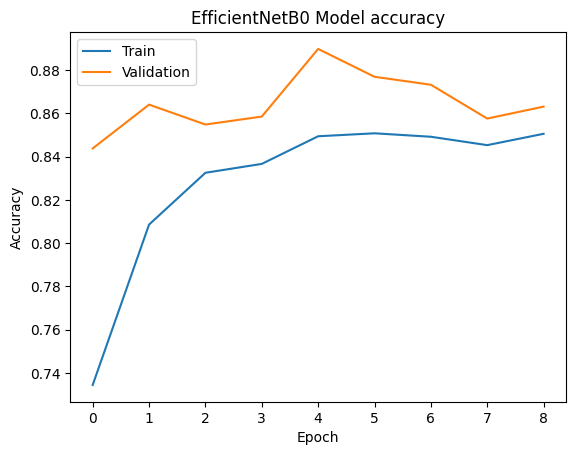

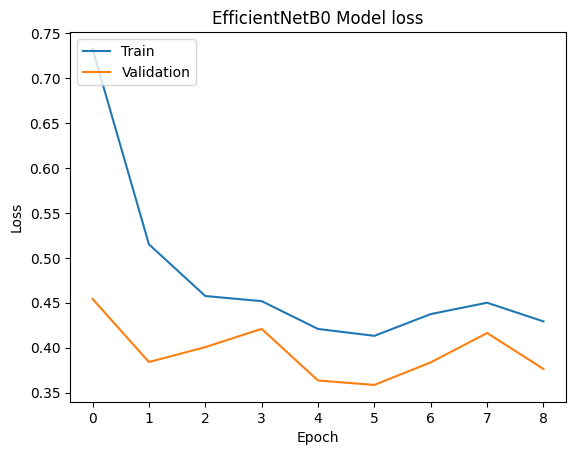

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
#############Run main function##############
if __name__ == "__main__":
    main()